In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
import requests
import re
from bs4 import BeautifulSoup

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from word2number import w2n

from datetime import datetime, timedelta


In [8]:
data_dir = "./lithium_dataset"
cleaned_data_dir = "./lithium_dataset/cleaned_data"

## Price Data Ingestion + Processing
- Consider lithium future, lithium metal spot, Li2CO3, and LIOH prices are potential regressands
- Clean each by calculating all available log returns with lags 1, 7, and 14 days
- According to Professor Geard, we'll only use data from 2021, which would include on average 500-600 datapoints
- Store them in jerry/lithium_dataset/cleaned_data

In [25]:
def convert_string_to_numeric(s):
    """
    Convert strings like '5.74M' or '532.50K' to numeric values
    """
    s = str(s).replace(',', '')  # Remove commas
    if 'M' in s:
        return float(s.replace('M', '')) * 1e6
    elif 'K' in s:
        return float(s.replace('K', '')) * 1e3
    else:
        return float(s)


def process_price_dataframe(df, price_cols, date_format, lags):

    # Convert columns in price_cols from string to numeric
    for col in price_cols:
        if type(df.loc[0,col]) == str:
            df[col] = df[col].apply(convert_string_to_numeric)
        else: 
            df[col] = df[col].astype(float)

    # Processing Dates
    df['Date'] = df['Date'].str.replace('.', '')
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    for lag in lags:
        df[f'lag_{lag}'] = df.loc[:,'Date'] - timedelta(days=lag)
    df.set_index('Date', inplace=True)
    df = df.sort_index(ascending=True)
    for lag in lags:
        df[f'lag_{lag}_price'] = df[f'lag_{lag}'].apply(lambda x: df.loc[x,'Close'] if x in df.index else np.NaN)
        df = df.drop(columns=[f'lag_{lag}'])
        df[f'lag_{lag}_log_return'] = np.log(df['Close'] / df[f'lag_{lag}_price'])

    return df

In [26]:
regressands = ['60C-LTCX', '99C-LTCB', '995C-LTCB', '99MIN-LTMT', '999MIN-LTMT']
lags = [1,7,14]
all_data = {k: None for k in regressands}

all_data['li_future'] = pd.read_excel(f"{data_dir}/Historical Prices (9).xlsx")[['Date', 'Close']]
all_data['li2co3'] = pd.read_csv(f"{data_dir}/Lithium Carbonate (wind database).csv").rename(columns={'Li2CO3 99%': 'Close'})
all_data['lioh'] = pd.read_csv(f"{data_dir}/Lithium Hydroxide (wind database).csv").rename(columns={'LiOH 56.5%': 'Close'})
for reg in regressands:
    all_data[reg] = pd.read_csv(f"{data_dir}/{reg}.csv")[['Date', 'Price']].rename(columns={'Price':'Close'})

for reg in all_data.keys():
    if reg == 'li_future':
        all_data[reg] = process_price_dataframe(all_data[reg], price_cols=['Close'], date_format='%b %d, %Y', lags=lags)
    elif reg in ['li2co3', 'lioh']:
        all_data[reg] = process_price_dataframe(all_data[reg], price_cols=['Close'], date_format='%Y-%m-%d', lags=lags)
    else:
        all_data[reg] = process_price_dataframe(all_data[reg], price_cols=['Close'], date_format='%m/%d/%Y', lags=lags)
    all_data[reg].to_csv(f"{cleaned_data_dir}/{reg}_cleaned.csv")

all_data['li2co3']

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = geta

,Close,lag_1_price,lag_1_log_return,lag_7_price,lag_7_log_return,lag_14_price,lag_14_log_return
Date,,,,,,,
2005-01-04,23200.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,23200.0,23200.0,0.000000,NaN,NaN,NaN,NaN
2005-01-06,23200.0,23200.0,0.000000,NaN,NaN,NaN,NaN
2005-01-07,23200.0,23200.0,0.000000,NaN,NaN,NaN,NaN
2005-01-10,23200.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-05-16,265000.0,258000.0,0.026770,195500.0,0.304169,NaN,NaN
2023-05-17,274000.0,265000.0,0.033398,208500.0,0.273189,NaN,NaN
2023-05-18,290000.0,274000.0,0.056753,225000.0,0.253781,179500.0,0.479706


## News Data Ingestion
- Use lithium_merged.csv as the source of all Lithium-related news
- Only keep news url and tone, which would be used to fetch all text contents --> NLP

In [27]:
news = pd.read_csv(f'{data_dir}/lithium_merged.csv')
news.set_index('DATE', inplace=True)
news.index = pd.to_datetime(news.index, format = '%Y%m%d%H%M%S')
news = news.sort_index(ascending = True)['2017-05-02':]
news = news[['DocumentIdentifier', 'V2Tone']].rename(columns={'DocumentIdentifier': 'url', 'V2Tone': 'tone'})

display(news)

,url,tone
DATE,,
2017-05-02 13:30:00,https://www.insiderfinancial.com/lithium-x-ene...,0.818554
2017-05-02 15:30:00,http://www.prnewswire.com/news-releases/hotter...,-1.374570
2017-05-03 06:00:00,http://www.einnews.com/pr_news/379071017/power...,0.000000
2017-05-03 11:00:00,http://www.einnews.com/pr_news/379118179/nemas...,-0.092593
2017-05-03 13:30:00,http://www.finanznachrichten.de/nachrichten-20...,0.207469
...,...,...
2023-05-30 22:00:00,https://www.sandiegoreader.com/news/2023/may/3...,-4.336043
2023-05-31 00:30:00,https://www.havasunews.com/nation/could-the-ru...,-3.505911
2023-05-31 12:00:00,https://www.finanznachrichten.de/nachrichten-2...,-0.213447


## Combine News & Price Data to Generate Labels

In [30]:
### Combine news and corresponding price data
news['date'] = [datetime.date(d).strftime('%Y-%m-%d') for d in news.index] 
def get_log_return(price_df, lag, timestamp):
    if timestamp in price_df.index:
        return price_df.loc[timestamp, lag]
    else:
        return np.NaN

for col in ['Close', 'lag_1_log_return', 'lag_7_log_return', 'lag_14_log_return']:
    news[col] = news['date'].apply(lambda x: get_log_return(all_data['li_future'], col, x))


### Generate labels using the given column & thresholds
thresholds = [0,0]
def num_to_label(num):
    if num < thresholds[0]:
        return 'SELL'
    elif num > thresholds[1]:
        return 'BUY'
    else:
        return 'HOLD'

for lag in [1,7,14]:
    news[f'lag_{lag}_label'] = news[f'lag_{lag}_log_return'].apply(lambda x: num_to_label(x))


### Final cleaning & saving data
news = news.drop(columns=['date'])['2021-01-01':]
news = news.dropna()
news.to_csv(f"{cleaned_data_dir}/news_price_cleaned.csv")
display(news.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1990 entries, 2021-01-01 00:45:00 to 2023-05-19 23:30:00
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                1990 non-null   object 
 1   tone               1990 non-null   float64
 2   Close              1990 non-null   float64
 3   lag_1_log_return   1990 non-null   float64
 4   lag_7_log_return   1990 non-null   float64
 5   lag_14_log_return  1990 non-null   float64
 6   lag_1_label        1990 non-null   object 
 7   lag_7_label        1990 non-null   object 
 8   lag_14_label       1990 non-null   object 
dtypes: float64(5), object(4)
memory usage: 155.5+ KB


None

## News Text Preprocessing: 
- get news content using newspaper library
- clean content using Spacy, NLTK, etc. Steps include:
    - Remove noise including urls, accented characters, mentions & hashtags, punctuations, and extra whitespaces
    - Convert all content to lowercase
    - Remove stopwords defined by spacy & manual input
    - Remove numbers
    - Lemmatize the text
- Store all text content corresponding to each news article in a large df, removing unfetchable news --> save csv

In [7]:
sw_nltk = nltk.corpus.stopwords.words("english")
sw_spacy = spacy_nlp.Defaults.stop_words
exclude_stopwords = ['one', 'two', 'three', 'four', 'five', 'six', 'eight', 'nine', 'ten', 'twelve', 'fifteen', 'twenty', 'forty', 'fifty', 'sixty', 'hundred', 'not', ]
include_stopwords = ['email', 'phone', 'contact', 'information', 'link', 'tel']
sw_spacy = [word for word in sw_spacy if word not in exclude_stopwords]
sw_spacy = sw_spacy + include_stopwords
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

news_text = news.copy()[:10]
news_text['text'] = news_text.loc[:,'url'].apply(lambda x: url_to_clean_text(url=x, stopwords=sw_spacy, lemmatizer=wordnet_lemmatizer, remove_num_or_not=True, language=None))
news_text = news_text[(news_text['text'] != 1) & (news_text['text'] != '')]

news_text.to_csv('news_text.csv')

,url,tone,Close,lag_1_log_return,lag_7_log_return,lag_14_log_return,lag_1_label,lag_7_label,lag_14_label,text
DATE,,,,,,,,,,
2021-01-01 00:45:00,https://www.bestmag.co.uk/indnews/jci-queers-p...,1.562500,46500.0,0.0,0.010811,0.125880,HOLD,BUY,BUY,lead pressure group including international le...
2021-01-01 04:15:00,https://www.carandbike.com/news/tesla-secures-...,0.766284,46500.0,0.0,0.010811,0.125880,HOLD,BUY,BUY,tesla secured longterm deal supply lithium hyd...
2021-01-05 00:15:00,https://investingnews.com/news/lithium-investi...,2.462621,46500.0,0.0,0.000000,0.010811,HOLD,HOLD,BUY,copyright c dig medium incyour trusted source ...
2021-01-05 18:00:00,https://www.naija247news.com/2021/01/05/lithiu...,0.506329,46500.0,0.0,0.000000,0.010811,HOLD,HOLD,BUY,price lithiumion battery pack power electric v...
2021-01-05 19:30:00,https://www.gastongazette.com/story/news/2021/...,0.833333,46500.0,0.0,0.000000,0.010811,HOLD,HOLD,BUY,randy hastings look property aderholdt road no...
2021-01-06 05:30:00,https://investingnews.com/daily/resource-inves...,-0.894855,46500.0,0.0,0.000000,0.010811,HOLD,HOLD,BUY,lithium price fallen recent high expert remain...
2021-01-06 11:30:00,https://www.business-live.co.uk/enterprise/lit...,4.118404,46500.0,0.0,0.000000,0.010811,HOLD,HOLD,BUY,went wrong try later invalid went wrong try la...
2021-01-07 12:15:00,https://www.prnewswire.com:443/news-releases/a...,2.739726,46500.0,0.0,0.000000,0.010811,HOLD,HOLD,BUY,charlotte nc january prnewswire albemarle corp...


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8 entries, 2021-01-01 00:45:00 to 2021-01-07 12:15:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                8 non-null      object 
 1   tone               8 non-null      float64
 2   Close              8 non-null      float64
 3   lag_1_log_return   8 non-null      float64
 4   lag_7_log_return   8 non-null      float64
 5   lag_14_log_return  8 non-null      float64
 6   lag_1_label        8 non-null      object 
 7   lag_7_label        8 non-null      object 
 8   lag_14_label       8 non-null      object 
 9   text               8 non-null      object 
dtypes: float64(5), object(5)
memory usage: 704.0+ bytes


None

# Model Training

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [9]:
news_text = pd.read_csv(f"{cleaned_data_dir}/news_text_cleaned.csv", index_col=0)
news_text.set_index('DATE', inplace=True)

news_text[news_text['lag_7_label'] == 'HOLD'] = 'SELL'

display(news_text[['lag_1_label', 'lag_7_label', 'lag_14_label', 'text']])
display(news_text['lag_7_label'].value_counts())

,lag_1_label,lag_7_label,lag_14_label,text
DATE,,,,
2021-01-01 00:45:00,HOLD,BUY,BUY,lead pressure group including international le...
2021-01-01 04:15:00,HOLD,BUY,BUY,tesla secured longterm deal supply lithium hyd...
2021-01-05 00:15:00,SELL,SELL,SELL,SELL
2021-01-05 18:00:00,SELL,SELL,SELL,SELL
2021-01-05 19:30:00,SELL,SELL,SELL,SELL
...,...,...,...,...
2023-04-10 22:15:00,HOLD,SELL,SELL,vancouver april prnewswire sigma lithium corpo...
2023-04-10 22:30:00,HOLD,SELL,SELL,welcome hope restful long easter weekend frien...
2023-04-12 07:30:00,HOLD,SELL,SELL,vieux comptoir option agreement superior minin...


lag_7_label
SELL    721
BUY     582
Name: count, dtype: int64

[-0.76638945 -0.62490519]
0.48466257668711654


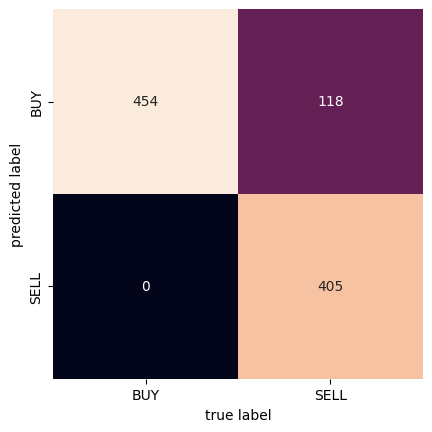

In [12]:
X = news_text['text']
Y = news_text['lag_7_label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=False)

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, Y_train)
pred = model.predict(X_train)

params = model.get_params(deep=True)
score = model.score(X_test, Y_test)
coef = list(zip(model[1].feature_log_prob_[0], model[0].get_feature_names_out()))
print(model[1].class_log_prior_)
print(score)
# print(coef)


# def show_top10(classifier, vectorizer, categories):
#     feature_names = np.asarray(vectorizer.get_feature_names_out())
#     for i, category in enumerate(categories):
#         top10 = np.argsort(classifier.feature_log_prob_[i])[-10:]
#         print("%s: %s" % (category, " ".join(feature_names[top10])))

# # print(model[0])
# show_top10(model[1], model[0], Y_train.unique())



from sklearn.metrics import confusion_matrix
mat = confusion_matrix(Y_train, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=Y_train.unique(), yticklabels=Y_train.unique())
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [149]:
vec = CountVectorizer()
X = vec.fit_transform(news_text['text'])
matrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
display(matrix)
print(*matrix.columns, sep= ', ')

,0004,0006,0008,0019,002460sz,0026,003,0034,010deg,020deg,...,zoro1,zoros,zou,zu,zuckerberg,zuleta,zulu,zunaid,zurich,zusammenarbeit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1299,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0004, 0006, 0008, 0019, 002460sz, 0026, 003, 0034, 010deg, 020deg, 02nd, 031gt, 036, 03rd, 040deg, 051910ks, 06gw, 075ca, 081, 082, 085inw0042, 100000squarefoot, 10000hectare, 1000am, 1000tday, 100interest, 100kw, 100metre, 100mtpa, 100owned, 100percent, 100percentowned, 100success, 101021acsami0c21586, 1015am, 102b, 1030am, 1037iw, 1043mt, 10500mtpa, 1050mgl, 107, 107mt, 10day, 10f, 10k, 10ka, 10kmlong, 10ksb, 10mw, 10q, 10th, 10x, 1100acres, 1100kt, 1135kt, 113of, 118mt, 11bn, 11th, 120ah, 120day, 1211hong, 122tn, 1230am, 1250kt, 125year, 128primarily, 12day, 12month, 12p, 12th, 12v, 12v360ah, 12volt, 12x, 13000squaremile, 130million, 1340ppm, 135member, 13b, 13bn, 13d, 13f, 13th, 140pm, 140tonne, 143, 144, 144kw, 1450kt, 1458acre, 14member, 14mt, 14th, 150000tpa, 1500meter, 1500tonne, 150million, 150millionplus, 1525acre, 155million, 15b, 15degc, 15oc, 15th, 15v, 160degf, 1660, 16day, 16gwh, 16th, 16thbrll, 174000foot, 175b, 17fold, 17mt, 17th, 1800ppm, 1800redchip, 180200gwh, 18600

# Model Inference + Feature Generation